<a href="https://colab.research.google.com/github/A-Istrate/80629_Project/blob/main/ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import os
import re
from tensorflow.keras import layers
from sklearn.utils import class_weight

Checking our images

In [58]:
## images path
path_s = r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers"
path = pathlib.Path(path_s)
image_count=len(list(path.glob('*/*.jpg')))
print(image_count)

53378


Checking a childrens book

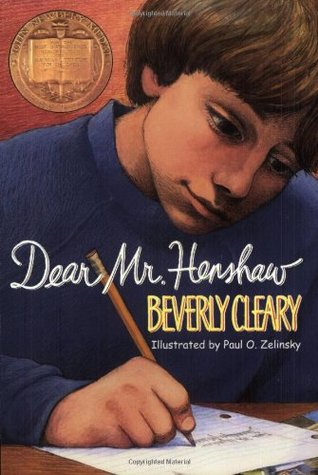

In [59]:
children = list(path.glob('Childrens/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [60]:
batch_size =32
img_height = 150
img_width =100

list_ds = tf.data.Dataset.list_files(str(path_s+"\*/*.jp*"),shuffle=False)
list_ds = list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [6]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Other\\24319.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Historical\\23674.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Young Adult\\17694.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Poetry\\11612.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Historical\\17069.jpg'


In [61]:
class_names = np.array(sorted([item.name for item in path.glob('*') if os.path.isdir(item)]))
print(class_names)

['Childrens' 'Classics' 'Cultural' 'Fantasy' 'Historical' 'History'
 'Horror' 'Mystery' 'Other' 'Poetry' 'Romance' 'Science Fiction'
 'Sequential Art' 'Young Adult']


In [62]:
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [63]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

42703
10675


In [ ]:
[object.numpy() for object in val_ds][0]

In [ ]:
v2 = pd.DataFrame([re.findall("\d+\.jpg",str(object.numpy())) for object in val_ds])

In [ ]:
%store -r final_genres_filtered

In [ ]:
df_merge = pd.merge(v2,final_genres_filtered,left_on=0,right_on="img")

In [64]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [65]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [66]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    #if tf.io.is_jpeg(file_path):
     #   img = decode_img(img)
   # else:
     #   print("error : %s is not a jpg" %file_path)
    return img,label


In [67]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds2 = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds2 = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


Image shape:  (150, 100, 3)
Label:  11


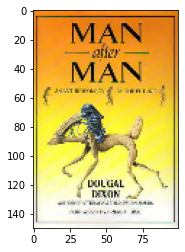

In [68]:
for image, label in train_ds2.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image.numpy().astype("uint8"))

In [69]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  #print(ds)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds2 = configure_for_performance(train_ds2)
val_ds2 = configure_for_performance(val_ds2)

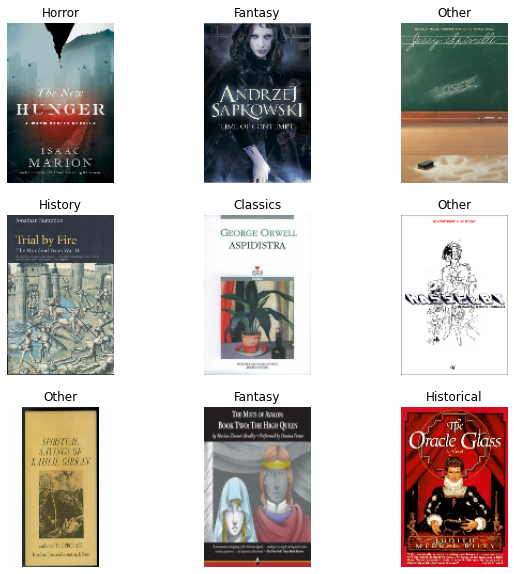

In [70]:
image_batch, label_batch = next(iter(train_ds2))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Classes

In [71]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=14

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=0.0001, rho=0.9, momentum=0.0, epsilon=0.001, 
    name='RMSprop'
),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [72]:
history=model.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=15
)

Epoch 1/15
1335/1335 [==============================] - 210s 156ms/step - loss: 2.1610 - accuracy: 0.3573 - val_loss: 2.1363 - val_accuracy: 0.3307
Epoch 2/15
1335/1335 [==============================] - 198s 149ms/step - loss: 2.0696 - accuracy: 0.3672 - val_loss: 2.0568 - val_accuracy: 0.3742
Epoch 3/15
1335/1335 [==============================] - 189s 142ms/step - loss: 2.0170 - accuracy: 0.3776 - val_loss: 2.0381 - val_accuracy: 0.3687
Epoch 4/15
1335/1335 [==============================] - 194s 146ms/step - loss: 1.9815 - accuracy: 0.3854 - val_loss: 1.9848 - val_accuracy: 0.3915
Epoch 5/15
1335/1335 [==============================] - 196s 147ms/step - loss: 1.9410 - accuracy: 0.3944 - val_loss: 1.9765 - val_accuracy: 0.3907
Epoch 6/15
1335/1335 [==============================] - 196s 147ms/step - loss: 1.8958 - accuracy: 0.4023 - val_loss: 1.9536 - val_accuracy: 0.3961
Epoch 7/15
1335/1335 [==============================] - 199s 149ms/step - loss: 1.8539 - accuracy: 0.4134 - val_

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in val_ds]

In [ ]:
validation_classes = np.concatenate(vclasses).ravel()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

In [ ]:
def prediction_score(valid,predictions,cnames=class_names):
    pred = np.argmax(predictions, axis=1)
    pred2 = np.argsort(predictions,axis=1)[:,-2]
    pred3 = np.argsort(predictions,axis=1)[:,-3]
    dict_c = dict(enumerate(cnames))
    scores=[]
    for v,p1,p2,p3 in zip(valid,pred,pred2,pred3):
        score=0
        if v == p1: score=1
        elif v == p2: score =0.75
        elif v == p3: score =0.5
        scores.append([dict_c.get(v),score])
    scores_df = pd.DataFrame(scores,columns=["genre","score"])
    meanscore =np.round(scores_df["score"].mean(),3)
    print("The average score is %s" %meanscore)
    return scores_df.groupby("genre").mean("score")

In [ ]:
prediction_score(validation_classes,predictions)